Model: siglip-so400m-patch14-384
Number of probabilities in each range:
> 0.0 and <= 0.1: 1286
> 0.1 and <= 0.2: 125
> 0.2 and <= 0.3: 76
> 0.3 and <= 0.4: 48
> 0.4 and <= 0.5: 45
> 0.5 and <= 0.6: 47
> 0.6 and <= 0.7: 31
> 0.7 and <= 0.8: 40
> 0.8 and <= 0.9: 51
> 0.9 and <= 1.0: 115
Probability ranges saved to probability_ranges.csv


/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp/T/ipykernel_30794/3876439350.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_probs = torch.load(os.path.join(model_na

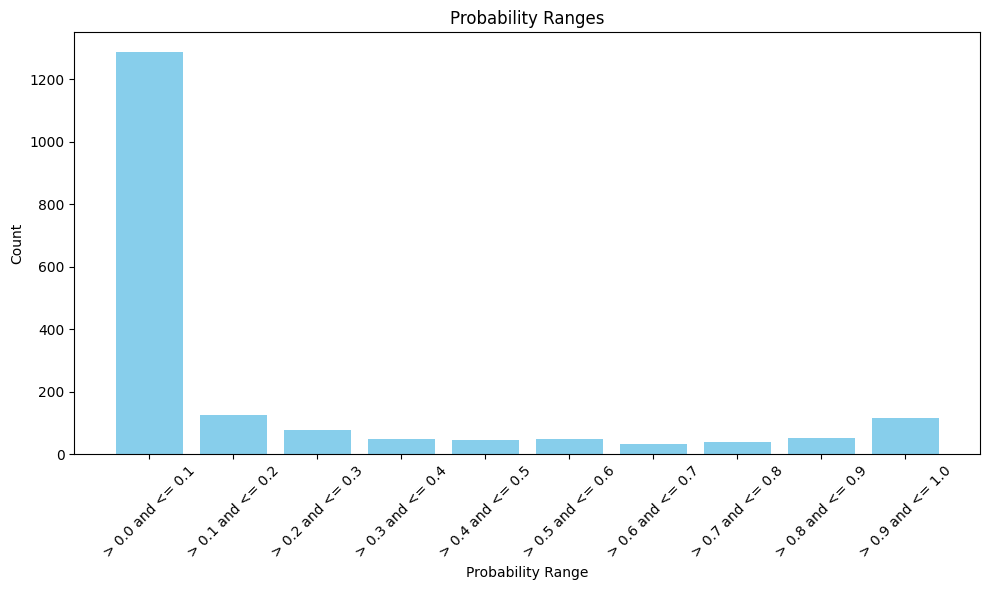

In [14]:
import pandas as pd
import torch
import os

models = ["clip-vit-base-patch32", "clip-vit-base-patch16", "clip-vit-large-patch14", "siglip-base-patch16-512", "siglip-large-patch16-384", "siglip-so400m-patch14-384"]

model_name = models[5]

print(f"Model: {model_name}")

all_probs = torch.load(os.path.join(model_name, 'probs.pt'))

ranges = [(i / 10, (i + 1) / 10) for i in range(10)]
range_counts = {f"> {r[0]:.1f} and <= {r[1]:.1f}": 0 for r in ranges}

# Count the number of probabilities in each range
for probs_row in all_probs:
  prob = torch.max(probs_row).item()
  for r in ranges:
    if r[0] < prob <= r[1]:
      range_counts[f"> {r[0]:.1f} and <= {r[1]:.1f}"] += 1

print("Number of probabilities in each range:")
for r, count in range_counts.items():
  print(f"{r}: {count}")
  
# Save the DataFrame to a CSV file
range_counts_df = pd.DataFrame(list(range_counts.items()), columns=['Range', 'Count'])
range_counts_df.to_csv(os.path.join(model_name, 'probability_ranges.csv'), index=False)
print("Probability ranges saved to probability_ranges.csv")
import matplotlib.pyplot as plt

# Plot all columns of the range counts
plt.figure(figsize=(10, 6))
plt.bar(range_counts_df['Range'], range_counts_df['Count'], color='skyblue')
plt.xlabel('Probability Range')
plt.ylabel('Count')
plt.title('Probability Ranges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import torch
import os
import tabulate
import json
from sklearn.metrics import confusion_matrix

# Load model data
all_probs = torch.load(os.path.join(model_name, 'probs.pt'))

# Load classes
with open(os.path.join(os.pardir, 'classes.txt'), 'r') as f:
  classes = [tuple(line.strip().split(',')) for line in f]

# Create ground truth dictionary
with open(os.path.join(os.pardir, '2_ground_truth.json'), 'r') as json_file:
  ground_truth_data = json.load(json_file)
ground_truth_dict = {item['item']: item['class'] for item in ground_truth_data}

# Load images names
with open(os.path.join(os.pardir, '2_test.txt'), 'r') as file:
  images = file.read().splitlines()

output_dir = f'../evaluations/{model_name}'
os.makedirs(output_dir, exist_ok=True)

class_names = [cls[1] for cls in classes]

# Create confusion matrix using ground truth and predicted classes
y_true = [ground_truth_dict.get(item) for item in images]
y_pred = [classes[all_probs[i].argmax().item()][1] for i in range(len(images))]
y_true_indices = [class_names.index(cls) for cls in y_true]
y_pred_indices = [class_names.index(cls) for cls in y_pred]
cm = confusion_matrix(y_true_indices, y_pred_indices, labels=range(len(class_names)))

# Convert confusion matrix to DataFrame for better readability
confusion_matrix_df = pd.DataFrame(cm, index=class_names, columns=class_names)

print("Confusion Matrix:")
print("Columns are predicted classes, rows are actual classes")
print(tabulate.tabulate(confusion_matrix_df, headers='keys', tablefmt='pretty'))
confusion_matrix_df.to_csv(os.path.join(output_dir, 'confusion_matrix.csv'))


Confusion Matrix:
Columns are predicted classes, rows are actual classes
+-------------------+------------------+------------------+------+-------------------+----------------+--------+---------------+-------------+-------+-----------------+
|                   | ANTHONY OF PADUA | JOHN THE BAPTIST | PAUL | FRANCIS OF ASSISI | MARY MAGDALENE | JEROME | SAINT DOMINIC | VIRGIN MARY | PETER | SAINT SEBASTIAN |
+-------------------+------------------+------------------+------+-------------------+----------------+--------+---------------+-------------+-------+-----------------+
| ANTHONY OF PADUA  |        10        |        0         |  0   |         0         |       0        |   0    |       4       |      0      |   0   |        0        |
| JOHN THE BAPTIST  |        0         |        74        |  0   |         0         |       0        |   0    |       2       |      0      |   0   |       23        |
|       PAUL        |        2         |        31        |  0   |         0      

/var/folders/cr/vlcyc1td3bb23qpwsjtlbfxw0000gp/T/ipykernel_30794/2496646907.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_probs = torch.load(os.path.join(model_nam

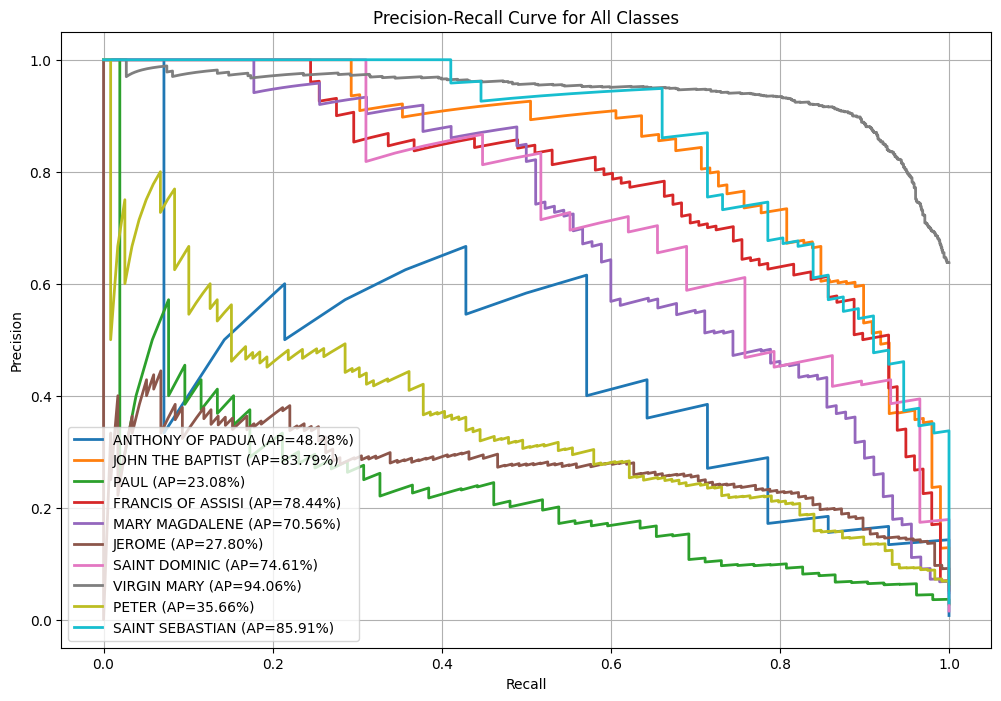

Metrics:
+----+-------------------+-------------+-----------+---------+----------+-------------------+
|    |    class_name     | # of Images | Precision | Recall  | F1 Score | Average Precision |
+----+-------------------+-------------+-----------+---------+----------+-------------------+
| 0  | ANTHONY OF PADUA  |     14      |   3.70%   | 71.43%  |  7.04%   |      48.28%       |
| 1  | FRANCIS OF ASSISI |     98      |  81.82%   |  9.18%  |  16.51%  |      78.44%       |
| 2  |      JEROME       |     118     |  37.31%   | 21.19%  |  27.03%  |      27.80%       |
| 3  | JOHN THE BAPTIST  |     99      |  33.33%   | 74.75%  |  46.11%  |      83.79%       |
| 4  |  MARY MAGDALENE   |     90      |  41.92%   | 92.22%  |  57.64%  |      70.56%       |
| 5  |       PAUL        |     52      |   0.00%   |  0.00%  |  0.00%   |      23.08%       |
| 6  |       PETER       |     119     |   0.00%   |  0.00%  |  0.00%   |      35.66%       |
| 7  |   SAINT DOMINIC   |     29      |  11.98%   

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

KEY_CLASS_NAME = 'class_name'
KEY_NUM_IMAGES = '# of Images'
KEY_PRECISION = 'Precision'
KEY_RECALL = 'Recall'
KEY_F1_SCORE = 'F1 Score'
KEY_AVG_PRECISION = 'Average Precision'

class_names = [cls for cls in class_names]

class_image_counts = {cls: 0 for cls in class_names}
for item in y_true:
  class_image_counts[item] += 1

# one vs all encoding
y_true_one_hot = label_binarize(y_true_indices, classes=range(len(class_names)))

# Calculate precision for each class
class_precisions = precision_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_recalls = recall_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_f1_scores = f1_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_avg_precisions = average_precision_score(y_true_one_hot, all_probs, average=None) * 100

# Plot precision-recall curve for all classes
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
  precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], all_probs[:, i])
  plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={class_avg_precisions[i]:.2f}%)')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Classes')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Store precision, recall, and f1 score for each class into a dataframe
metrics_df = pd.DataFrame({
    KEY_CLASS_NAME: class_names,
    KEY_NUM_IMAGES: [count for count in class_image_counts.values()],
    KEY_PRECISION: class_precisions,  
    KEY_RECALL: class_recalls,        
    KEY_F1_SCORE: class_f1_scores,    
    KEY_AVG_PRECISION: class_avg_precisions 
})

# Reorder the dataframe based on the specified class order
class_order = ["ANTHONY OF PADUA", "FRANCIS OF ASSISI", "JEROME", "JOHN THE BAPTIST", "MARY MAGDALENE", "PAUL", "PETER", "SAINT DOMINIC", "SAINT SEBASTIAN", "VIRGIN MARY"]
metrics_df[KEY_CLASS_NAME] = pd.Categorical(metrics_df[KEY_CLASS_NAME], categories=class_order + ["MEAN"], ordered=True)
metrics_df = metrics_df.sort_values(KEY_CLASS_NAME).reset_index(drop=True)

# Add mean values to the dataframe
mean_precision = precision_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_recall = recall_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_f1_score = f1_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_avg_precision = average_precision_score(y_true_indices, all_probs, average='macro') * 100

mean_values = {
    KEY_CLASS_NAME: 'Mean',
    KEY_NUM_IMAGES: '-',
    KEY_PRECISION: mean_precision,
    KEY_RECALL: mean_recall,
    KEY_F1_SCORE: mean_f1_score,
    KEY_AVG_PRECISION: mean_avg_precision
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_values])], ignore_index=True)

metrics_df[[KEY_PRECISION, KEY_RECALL, KEY_F1_SCORE, KEY_AVG_PRECISION]] = metrics_df[
    [KEY_PRECISION, KEY_RECALL, KEY_F1_SCORE, KEY_AVG_PRECISION]
].map(lambda x: f"{x:.2f}%")

print("Metrics:")
print(tabulate.tabulate(metrics_df, headers='keys', tablefmt='pretty'))
metrics_df.to_csv(os.path.join(output_dir,'metrics.csv'))